# Credit Risk EDA - German Credit Dataset

This notebook performs a full, professional-grade EDA for the German Credit dataset.  
It auto-detects a candidate target, computes class balance, runs data quality checks, univariate/bivariate/multivariate analyses, and exports tables & plots for modeling.

In [1]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import chi2_contingency, f_oneway
from sklearn.preprocessing import StandardScaler
import seaborn as sns

df = pd.read_csv('german_credit_data.csv')


Shape: (1000, 11)
Unnamed: 0           int64
Age                  int64
Sex                 object
Job                  int64
Housing             object
Saving accounts     object
Checking account    object
Credit amount        int64
Duration             int64
Purpose             object
Risk                 int64
dtype: object
Missing:
 Unnamed: 0            0
Age                   0
Sex                   0
Job                   0
Housing               0
Saving accounts     183
Checking account    394
Credit amount         0
Duration              0
Purpose               0
Risk                  0
dtype: int64
Duplicates: 0


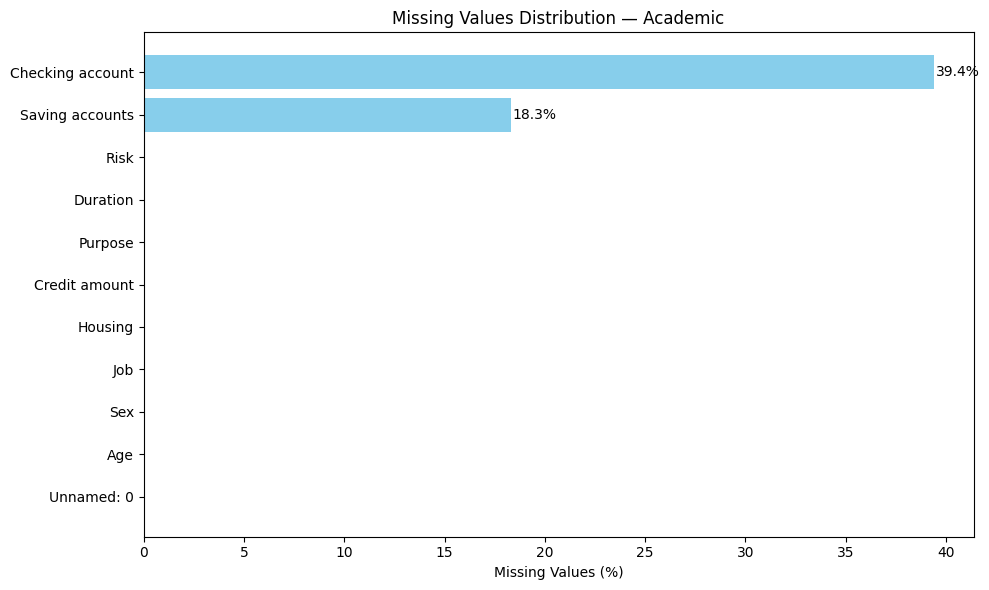

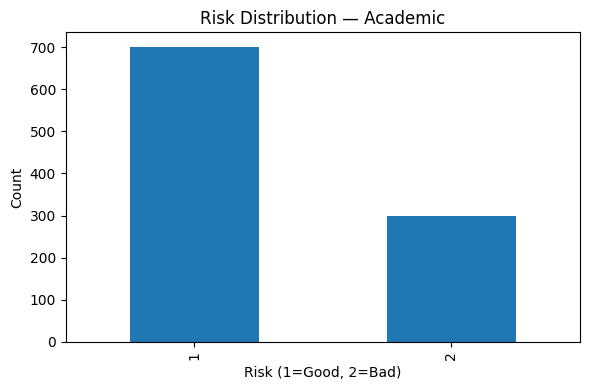

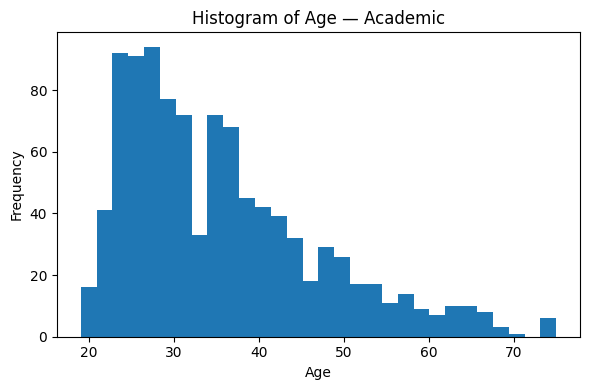

<Figure size 600x400 with 0 Axes>

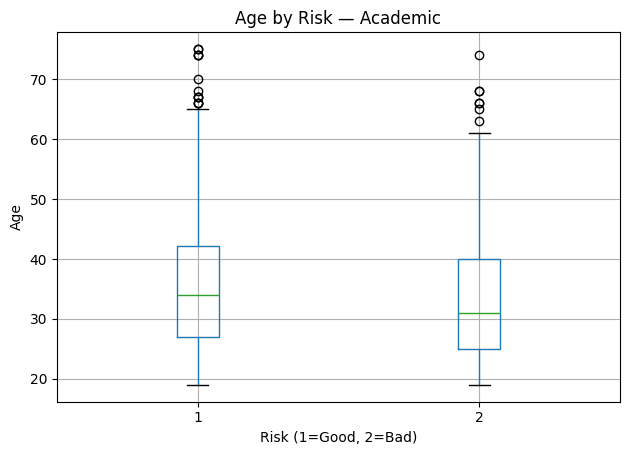

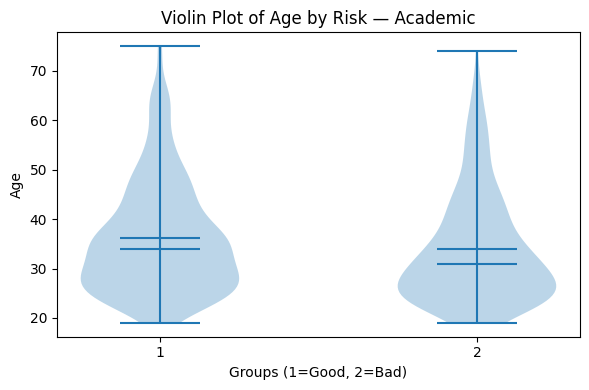

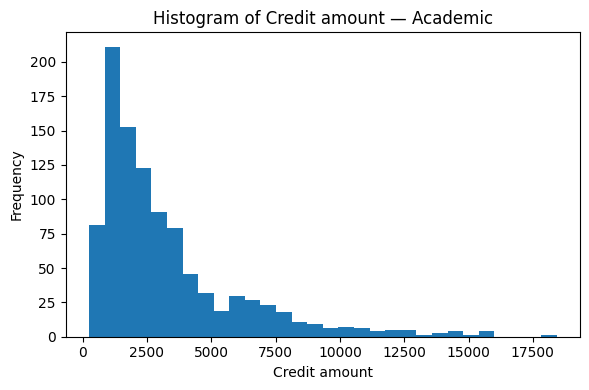

<Figure size 600x400 with 0 Axes>

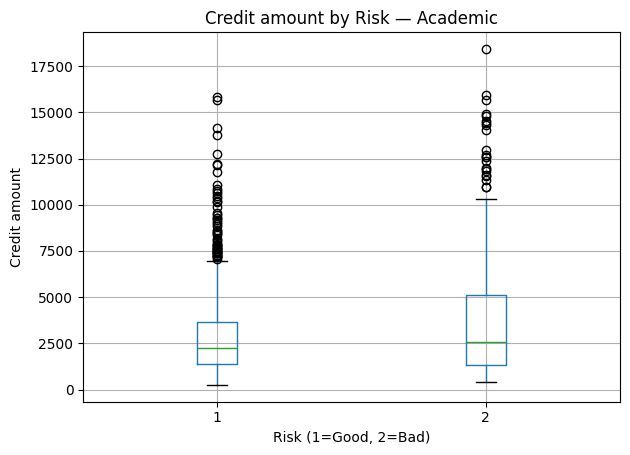

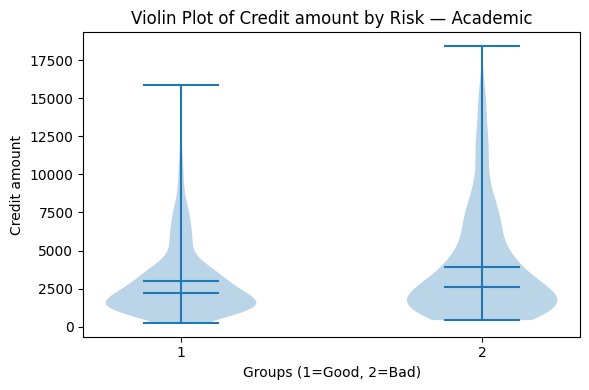

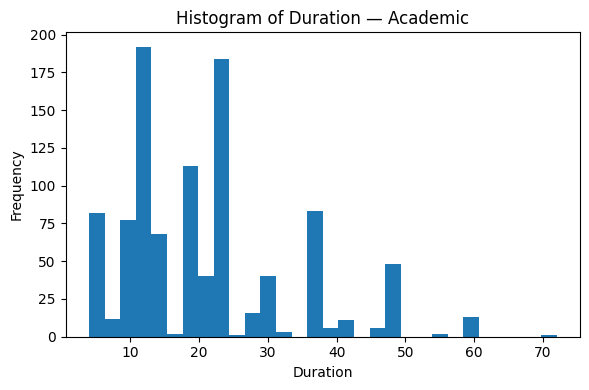

<Figure size 600x400 with 0 Axes>

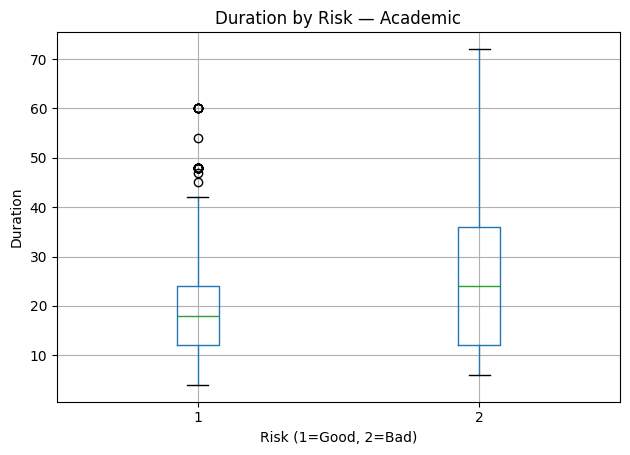

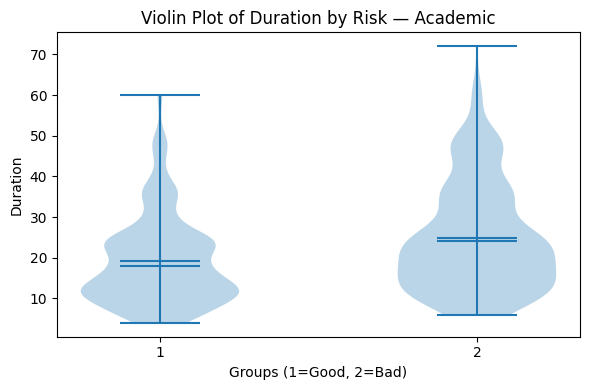

<Figure size 600x400 with 0 Axes>

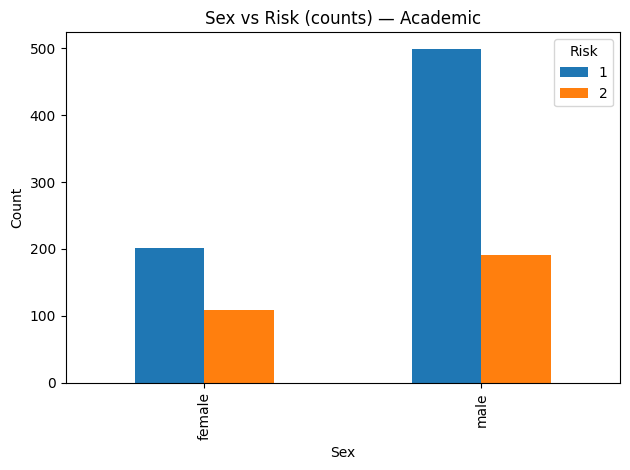

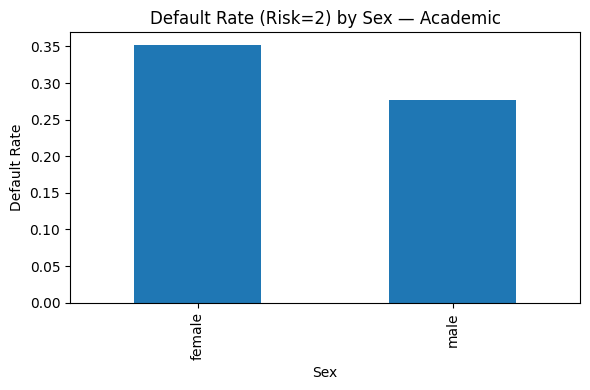

<Figure size 600x400 with 0 Axes>

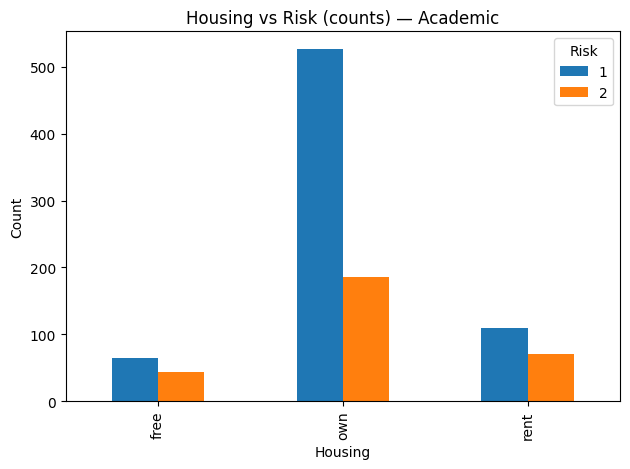

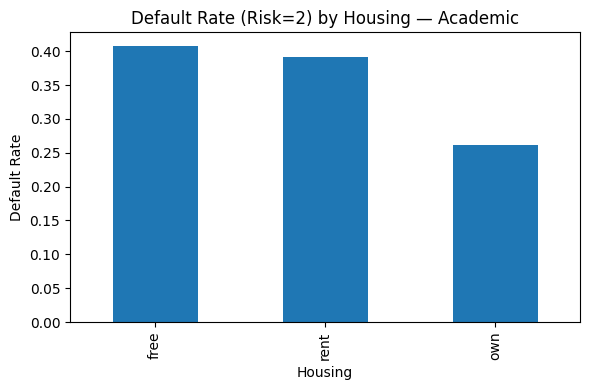

<Figure size 600x400 with 0 Axes>

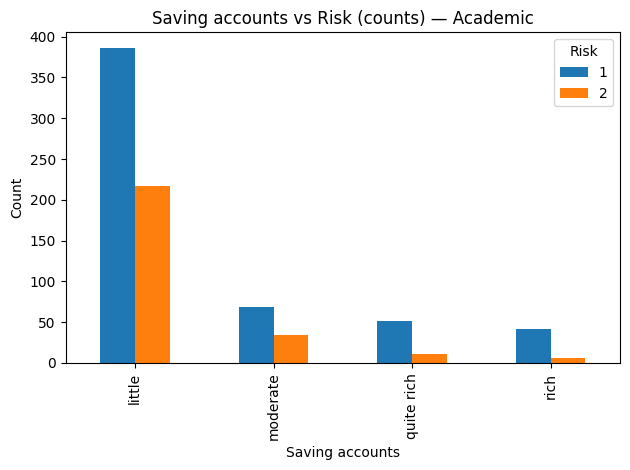

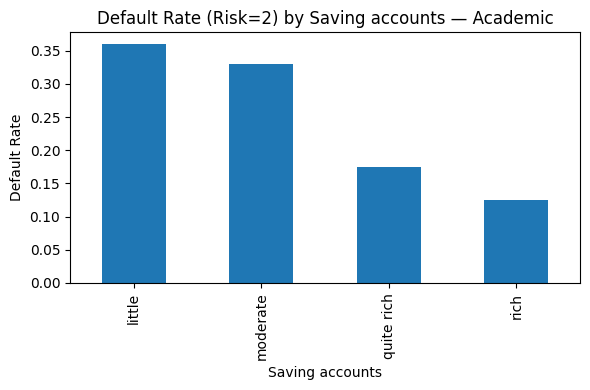

<Figure size 600x400 with 0 Axes>

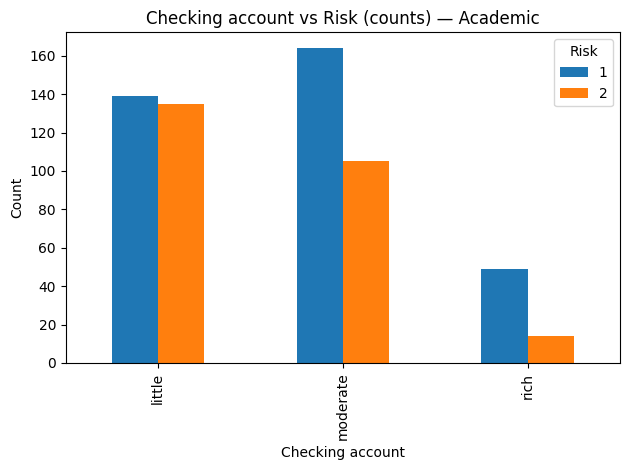

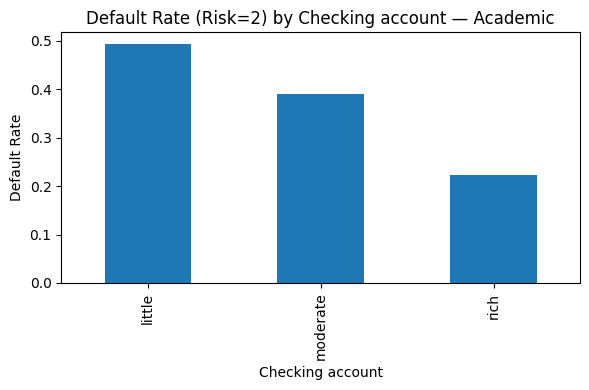

<Figure size 600x400 with 0 Axes>

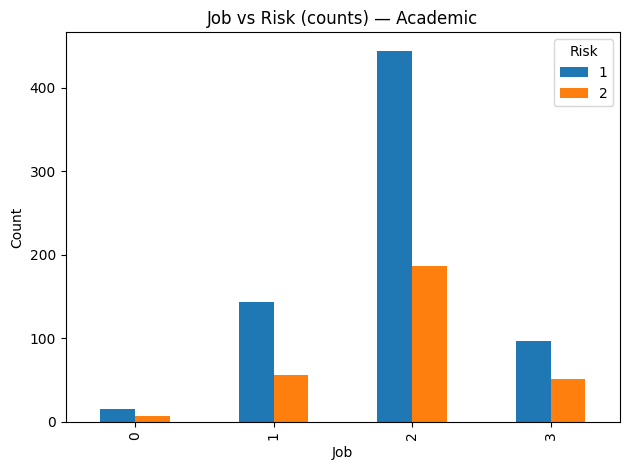

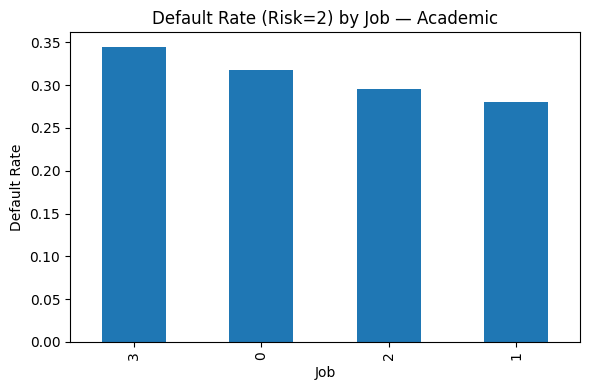

<Figure size 600x400 with 0 Axes>

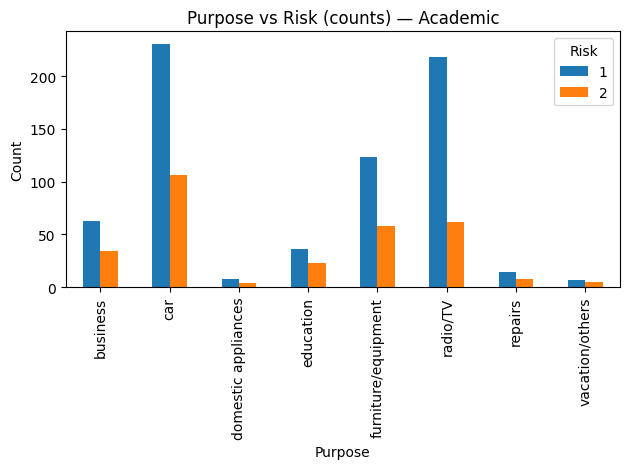

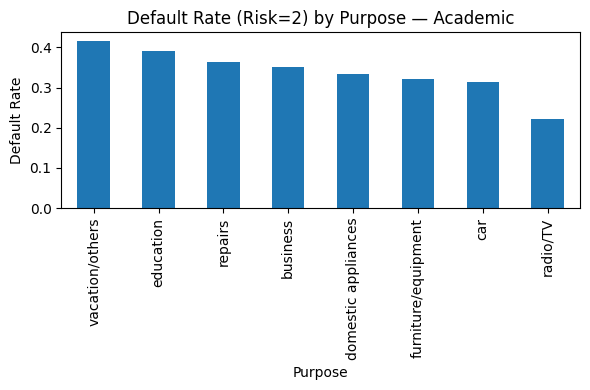

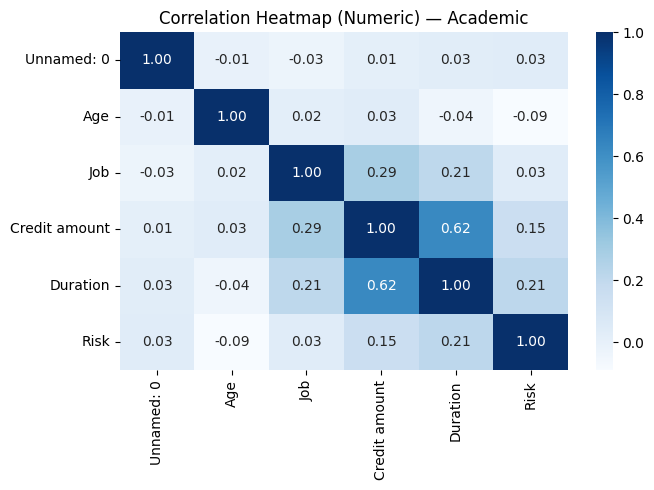

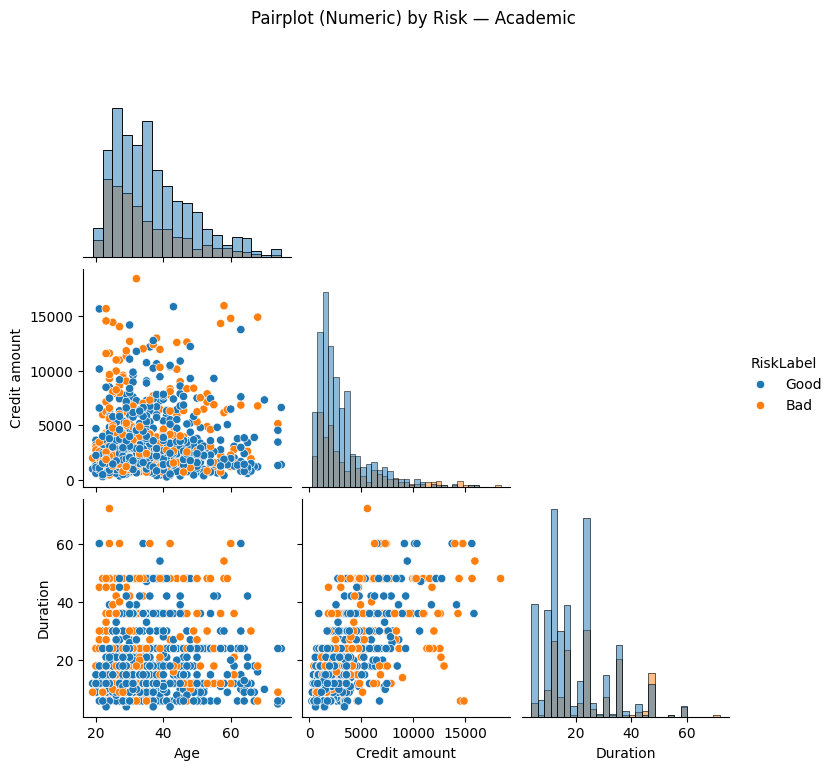


=== Statistical Association Tests ===
Chi-square Sex: chi2=5.3485, p=0.020740, dof=1
Chi-square Housing: chi2=18.1998, p=0.000112, dof=2
Chi-square Saving accounts: chi2=18.4791, p=0.000350, dof=3
Chi-square Checking account: chi2=17.0408, p=0.000199, dof=2
Chi-square Job: chi2=1.8852, p=0.596582, dof=3
Chi-square Purpose: chi2=13.6421, p=0.057926, dof=7
ANOVA Age: F=8.3570, p=0.003925
ANOVA Credit amount: F=24.4824, p=0.000001
ANOVA Duration: F=48.3338, p=0.000000
Prepared model-ready DataFrame (not saved to disk).
Figures saved to: german_eda


In [2]:

FIG_DIR = "german_eda"
os.makedirs(FIG_DIR, exist_ok=True)

def save_show(name, dpi=150):
    """Save the current active figure (plt.gcf()) to FIG_DIR/name and display it.

    This ensures we save the actual figure produced by pandas/seaborn/matplotlib plotting calls,
    which can otherwise end up saved as blank if the wrong figure object is used.
    """
    path = os.path.join(FIG_DIR, name)
    try:
        plt.gcf().tight_layout()
    except Exception:
        pass
    plt.gcf().savefig(path, bbox_inches="tight", dpi=dpi)
    plt.show()
    plt.close()

def plot_target_distribution(df):
    counts = df['Risk'].value_counts().sort_index()
    plt.figure(figsize=(6,4))
    counts.plot(kind='bar')
    plt.title("Risk Distribution — Academic")
    plt.xlabel("Risk (1=Good, 2=Bad)")
    plt.ylabel("Count")
    plt.tight_layout()
    save_show("01_risk_distribution.png")

def plot_numeric_box_by_risk(df, col):
    plt.figure(figsize=(6,4))
    df.boxplot(column=col, by='Risk')
    plt.title(f"{col} by Risk — Academic")
    plt.suptitle("")
    plt.xlabel("Risk (1=Good, 2=Bad)")
    plt.ylabel(col)
    plt.tight_layout()
    save_show(f"num_box_{col}_by_risk.png")

def plot_numeric_hist(df, col):
    # separate histograms for the column overall
    plt.figure(figsize=(6,4))
    plt.hist(df[col].dropna(), bins=30)
    plt.title(f"Histogram of {col} — Academic")
    plt.xlabel(col)
    plt.ylabel("Frequency")
    plt.tight_layout()
    save_show(f"hist_{col}.png")

def plot_violin_by_risk(df, col):
    # violin plot grouped by Risk using matplotlib
    data1 = df.loc[df['Risk']==1, col].dropna().values
    data2 = df.loc[df['Risk']==2, col].dropna().values
    plt.figure(figsize=(6,4))
    parts = plt.violinplot([data1, data2], showmeans=True, showmedians=True)
    plt.title(f"Violin Plot of {col} by Risk — Academic")
    plt.xlabel("Groups (1=Good, 2=Bad)")
    plt.ylabel(col)
    plt.xticks([1,2],[1,2])
    plt.tight_layout()
    save_show(f"violin_{col}_by_risk.png")

def plot_categorical_counts(df, col):
    ct = pd.crosstab(df[col], df['Risk'])
    plt.figure(figsize=(6,4))
    ct.plot(kind='bar')
    plt.title(f"{col} vs Risk (counts) — Academic")
    plt.xlabel(col)
    plt.ylabel("Count")
    plt.tight_layout()
    save_show(f"cat_counts_{col}.png")

def plot_categorical_default_rate(df, col):
    rates = df.groupby(col)['Risk'].apply(lambda s: (s==2).mean()).sort_values(ascending=False)
    plt.figure(figsize=(6,4))
    rates.plot(kind='bar')
    plt.title(f"Default Rate (Risk=2) by {col} — Academic")
    plt.xlabel(col)
    plt.ylabel("Default Rate")
    plt.tight_layout()
    save_show(f"cat_default_rate_{col}.png")

def plot_missing_heatmap(df):
    plt.figure(figsize=(10,6))
    missing = df.isna().sum().sort_values(ascending=True)
    missing_pct = (missing / len(df) * 100).round(2)
    
    # Create bar plot
    plt.barh(range(len(missing)), missing_pct, color='skyblue')
    
    # Customize the plot
    plt.yticks(range(len(missing)), missing.index)
    plt.xlabel('Missing Values (%)')
    plt.title('Missing Values Distribution — Academic')
    
    # Add percentage labels on the bars
    for i, v in enumerate(missing_pct):
        if v > 0:  # Only show labels for bars with missing values
            plt.text(v + 0.1, i, f'{v}%', va='center')
    
    plt.tight_layout()
    save_show("00_missing_values_heatmap.png")

def plot_correlation_heatmap(df):
    num_cols = df.select_dtypes(include=[np.number]).columns.tolist()
    corr = df[num_cols].corr()
    plt.figure(figsize=(7,5))
    ax = sns.heatmap(corr, annot=True, fmt=".2f", cmap="Blues", square=False)  # single-tone blue
    ax.set_title("Correlation Heatmap (Numeric) — Academic")
    plt.tight_layout()
    save_show("02_correlation_heatmap.png")

def plot_pairplot(df):
    # keep a small set of numeric columns for pairplot to stay readable
    num_candidates = [c for c in ['Age','Credit amount','Duration'] if c in df.columns]
    ppdf = df[num_candidates + ['Risk']].dropna()
    # map Risk to string labels for clear legend
    ppdf['RiskLabel'] = ppdf['Risk'].map({1:'Good', 2:'Bad'})
    g = sns.pairplot(ppdf, vars=num_candidates, hue='RiskLabel', corner=True, diag_kind='hist')
    g.fig.suptitle("Pairplot (Numeric) by Risk — Academic", y=1.02)
    out = os.path.join(FIG_DIR, "03_pairplot.png")
    g.fig.savefig(out, bbox_inches="tight", dpi=150)
    plt.show()

def chi_square_and_anova(df):
    print("\n=== Statistical Association Tests ===")
    cat_cols = [c for c in ['Sex','Housing','Saving accounts','Checking account','Job','Purpose'] if c in df.columns]
    for c in cat_cols:
        tbl = pd.crosstab(df[c], df['Risk'])
        chi2, p, dof, exp = chi2_contingency(tbl)
        print(f"Chi-square {c}: chi2={chi2:.4f}, p={p:.6f}, dof={dof}")
    for c in ['Age','Credit amount','Duration']:
        if c in df.columns:
            groups = [df.loc[df['Risk']==k, c].dropna() for k in sorted(df['Risk'].dropna().unique())]
            if len(groups)>=2:
                stat, p = f_oneway(*groups)
                print(f"ANOVA {c}: F={stat:.4f}, p={p:.6f}")

def clean_and_save(df):
    """Prepare a model-ready DataFrame but do NOT save to disk.

    Returns:
        df_model (pd.DataFrame): one-hot encoded and scaled DataFrame ready for modeling.
    """
    # Fill missing for common categoricals
    for col in ['Saving accounts','Checking account','Housing','Sex','Purpose']:
        if col in df.columns:
            df[col] = df[col].fillna('unknown')
    # One-hot encode categoricals
    cat_cols_all = df.select_dtypes(include=['object']).columns.tolist()
    df_model = pd.get_dummies(df, columns=cat_cols_all, drop_first=True)
    # Scale numerics
    scaler = StandardScaler()
    num_cols = [c for c in ['Age','Credit amount','Duration'] if c in df_model.columns]
    if num_cols:
        df_model[num_cols] = scaler.fit_transform(df_model[num_cols])
    # Previously the function saved df_model to CSV; that has been removed to avoid creating files.
    print("Prepared model-ready DataFrame (not saved to disk).")
    return df_model

def main():
    # Load
    src = "german_credit_data.csv"
    df = pd.read_csv(src)
    # Encode target
    df['Risk'] = df['Risk'].map({'good': 1, 'bad': 2})
    # Overview
    print("Shape:", df.shape)
    print(df.dtypes)
    print("Missing:\n", df.isna().sum())
    print("Duplicates:", df.duplicated().sum())
    # Visuals
    plot_missing_heatmap(df)
    plot_target_distribution(df)
    for col in ['Age','Credit amount','Duration']:
        if col in df.columns:
            plot_numeric_hist(df, col)
            plot_numeric_box_by_risk(df, col)
            plot_violin_by_risk(df, col)
    for col in ['Sex','Housing','Saving accounts','Checking account','Job','Purpose']:
        if col in df.columns:
            plot_categorical_counts(df, col)
            plot_categorical_default_rate(df, col)
    plot_correlation_heatmap(df)
    plot_pairplot(df)
    # Stats
    chi_square_and_anova(df)
    # Clean & prepare (no file will be created)
    prepared_df = clean_and_save(df)
    print(f"Figures saved to: {FIG_DIR}")

if __name__ == "__main__":
    main()


In [3]:
# === Chi-square tests for all columns vs target ===
# Robust: auto-load `df` if not present in kernel (so this cell can be run standalone)
from scipy.stats import chi2_contingency
from pathlib import Path
import pandas as pd

# Try to ensure df exists
if 'df' not in globals():
    # Try CSV_PATH if defined, otherwise look for common filenames
    candidate = None
    if 'CSV_PATH' in globals():
        candidate = Path(CSV_PATH)
    else:
        for name in ['german_credit_data.csv', 'Data/raw/german_credit_data.csv', './german_credit_data.csv']:
            p = Path(name)
            if p.exists():
                candidate = p
                break
    if candidate is None:
        raise NameError("DataFrame `df` is not defined in this notebook and no CSV path was found. Run the data-loading cell first or set CSV_PATH to a valid CSV file.")
    df = pd.read_csv(candidate)

results = []

target = 'Risk'
if target not in df.columns:
    raise KeyError(f"Target column '{target}' not found in DataFrame.")

# Iterate over columns except target
for col in df.columns:
    if col == target:
        continue
    # Treat as categorical if object/ categorical dtype OR small cardinality
    is_cat = pd.api.types.is_object_dtype(df[col]) or pd.api.types.is_categorical_dtype(df[col])
    if not is_cat:
        try:
            uniq = df[col].nunique(dropna=True)
        except Exception:
            uniq = 9999
        if uniq > 20:
            # skip high-cardinality numeric columns (not suitable for chi-square); record as skipped
            results.append({"feature": col, "p_value": None, "dof": None, "note": "skipped (high-cardinality)"})
            continue
    # build contingency table
    tab = pd.crosstab(df[col], df[target])
    # require at least a 2x2 table
    if tab.shape[0] < 2 or tab.shape[1] < 2:
        results.append({"feature": col, "p_value": None, "dof": None, "note": "insufficient levels for test"})
        continue
    try:
        chi2, p, dof, expected = chi2_contingency(tab)
        results.append({"feature": col, "p_value": float(p), "dof": int(dof), "note": "ok"})
    except Exception as e:
        results.append({"feature": col, "p_value": None, "dof": None, "note": f"error: {str(e)}"})

res_df = pd.DataFrame(results).sort_values(by=['p_value'], na_position='last')
# Ensure output dir exists
out_dir = Path(OUTPUT_DIR) if 'OUTPUT_DIR' in globals() else Path('german_eda')
out_dir.mkdir(exist_ok=True, parents=True)
(Path(out_dir) / 'tables').mkdir(exist_ok=True, parents=True)
res_df.to_csv(Path(out_dir) / 'tables' / 'chi2_summary.csv', index=False)

print(f"Saved chi-square summary to: {Path(out_dir)/'tables'/'chi2_summary.csv'}")
res_df


Saved chi-square summary to: german_eda\tables\chi2_summary.csv


C:\Users\kanaa\AppData\Local\Temp\ipykernel_32084\634977341.py:34: DeprecationWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, pd.CategoricalDtype) instead
  is_cat = pd.api.types.is_object_dtype(df[col]) or pd.api.types.is_categorical_dtype(df[col])
C:\Users\kanaa\AppData\Local\Temp\ipykernel_32084\634977341.py:34: DeprecationWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, pd.CategoricalDtype) instead
  is_cat = pd.api.types.is_object_dtype(df[col]) or pd.api.types.is_categorical_dtype(df[col])
C:\Users\kanaa\AppData\Local\Temp\ipykernel_32084\634977341.py:34: DeprecationWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, pd.CategoricalDtype) instead
  is_cat = pd.api.types.is_object_dtype(df[col]) or pd.api.types.is_categorical_dtype(df[col])


,feature,p_value,dof,note
4,Housing,0.000112,2.0,ok
6,Checking account,0.000199,2.0,ok
5,Saving accounts,0.000350,3.0,ok
2,Sex,0.020740,1.0,ok
9,Purpose,0.057926,7.0,ok
3,Job,0.596582,3.0,ok
0,Unnamed: 0,NaN,NaN,skipped (high-cardinality)
1,Age,NaN,NaN,skipped (high-cardinality)
7,Credit amount,NaN,NaN,skipped (high-cardinality)
8,Duration,NaN,NaN,skipped (high-cardinality)
